In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.svm import SVR
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### Data Sourcing

In [3]:
f_data = pd.read_csv("Finance_Data.csv")
e_data = pd.read_csv("Energy_Data.csv")
ev_data = pd.read_csv("Co2_Data.csv")

### Preprocessing

#### Finance Data

In [4]:
f_data.isnull().sum()  # Check for missing values
numeric_cols = ['Close/Last', 'Open', 'High', 'Low']
f_data[numeric_cols] = f_data[numeric_cols].fillna(f_data[numeric_cols].mean(), inplace=False)
scaler = StandardScaler()
f_data[['Close/Last', 'Open', 'High', 'Low']] = scaler.fit_transform(f_data[['Close/Last', 'Open', 'High', 'Low']])
f_data[['Close/Last', 'Open', 'High', 'Low']] = np.log(f_data[['Close/Last', 'Open', 'High', 'Low']])
f_data[numeric_cols] = f_data[numeric_cols].apply(pd.to_numeric, errors='coerce')
f_data = f_data.sort_values(by='Date')
f_data['Date'] = pd.to_datetime(f_data['Date'])
f_data_diff = f_data.diff().dropna()
f_data = f_data.dropna()
f_data['DateTime'] = pd.to_datetime(f_data['Date'])
f_data.set_index('DateTime', inplace=True)
f_data= f_data.sort_index()

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


#### Energy Data

In [5]:
e_data = e_data.sample(10000)
numeric_cols = ['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']
scaler = MinMaxScaler()
e_data[numeric_cols] = scaler.fit_transform(e_data[numeric_cols])
e_data[numeric_cols] = np.log(e_data[numeric_cols])
e_data['DateTime'] = pd.to_datetime(e_data['DateTime'])
e_data_diff = e_data.diff()[numeric_cols].dropna()
e_data = e_data.replace([np.inf, -np.inf], np.nan).dropna()
e_data['DateTime'] = pd.to_datetime(e_data['DateTime'])
e_data.set_index('DateTime', inplace=True)
e_data= e_data.sort_index()

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


#### Co2 Data

In [6]:
ev_data = ev_data.sample(10000)
ev_data.isnull().sum()
numeric_cols = ['x', 'y', 'mean_xco2', 'mean_xco2_anomaly']
ev_data[numeric_cols] = ev_data[numeric_cols].fillna(ev_data[numeric_cols].mean(), inplace=False)
scaler = MinMaxScaler()
ev_data[numeric_cols] = scaler.fit_transform(ev_data[numeric_cols])
ev_data[['mean_xco2', 'mean_xco2_anomaly']] = np.log(ev_data[['mean_xco2', 'mean_xco2_anomaly']])
ev_data_diff = ev_data.diff()[['mean_xco2', 'mean_xco2_anomaly']].dropna()
ev_data = ev_data.replace([np.inf, -np.inf], np.nan).dropna()
ev_data['Date'] = pd.to_datetime(ev_data['year'].astype(str) + '-' + ev_data['month'].astype(str))
ev_data.set_index('Date', inplace=True)
ev_data.drop(['year', 'month'], axis=1, inplace=True)
ev_data= ev_data.sort_index()

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


## Model Development

### Arima Model

#### Finance Data

Results of Dickey-Fuller Test:
Test Statistic                   -3.149069
p-value                           0.023129
#Lags Used                       16.000000
Number of Observations Used    1025.000000
Critical Value (1%)              -3.436746
Critical Value (5%)              -2.864364
Critical Value (10%)             -2.568274
dtype: float64


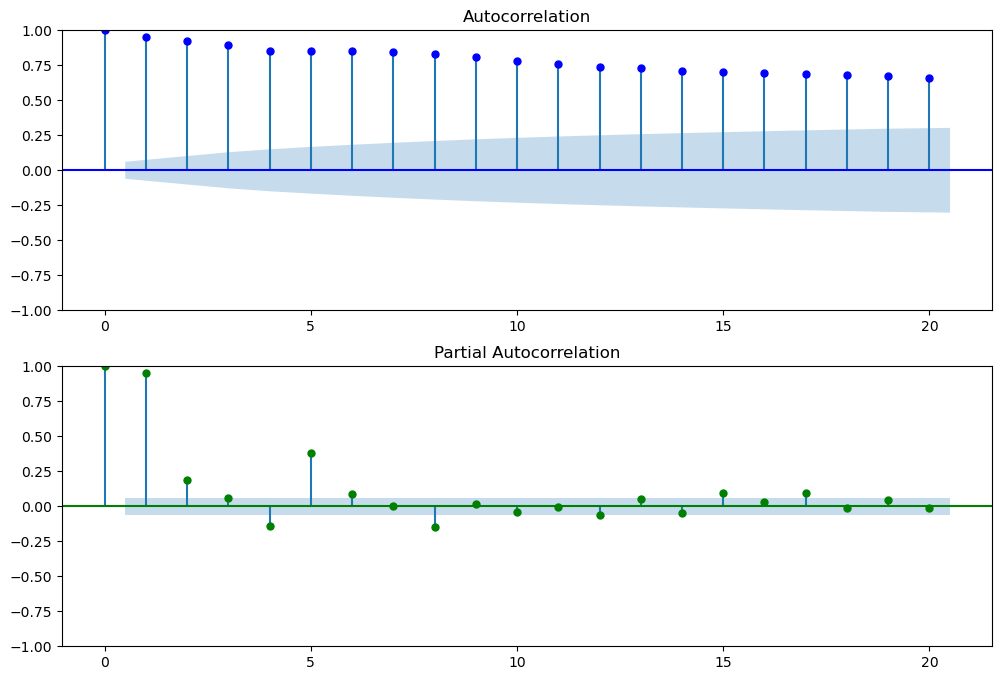

In [6]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    adf_result = adfuller(timeseries, autolag='AIC')
    result_series = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_result[4].items():
       result_series['Critical Value (%s)' % key] = value
    print(result_series)

adf_test(f_data['Close/Last'])

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(f_data['Close/Last'], lags=20, ax=axs[0], color='blue')
plot_pacf(f_data['Close/Last'], lags=20, ax=axs[1], color='green')
plt.show()


#### Energy Data

Results of Dickey-Fuller Test:
Test Statistic                -5.790398e+00
p-value                        4.887578e-07
#Lags Used                     2.500000e+01
Number of Observations Used    5.207000e+03
Critical Value (1%)           -3.431606e+00
Critical Value (5%)           -2.862095e+00
Critical Value (10%)          -2.567066e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -5.790398e+00
p-value                        4.887578e-07
#Lags Used                     2.500000e+01
Number of Observations Used    5.207000e+03
Critical Value (1%)           -3.431606e+00
Critical Value (5%)           -2.862095e+00
Critical Value (10%)          -2.567066e+00
dtype: float64


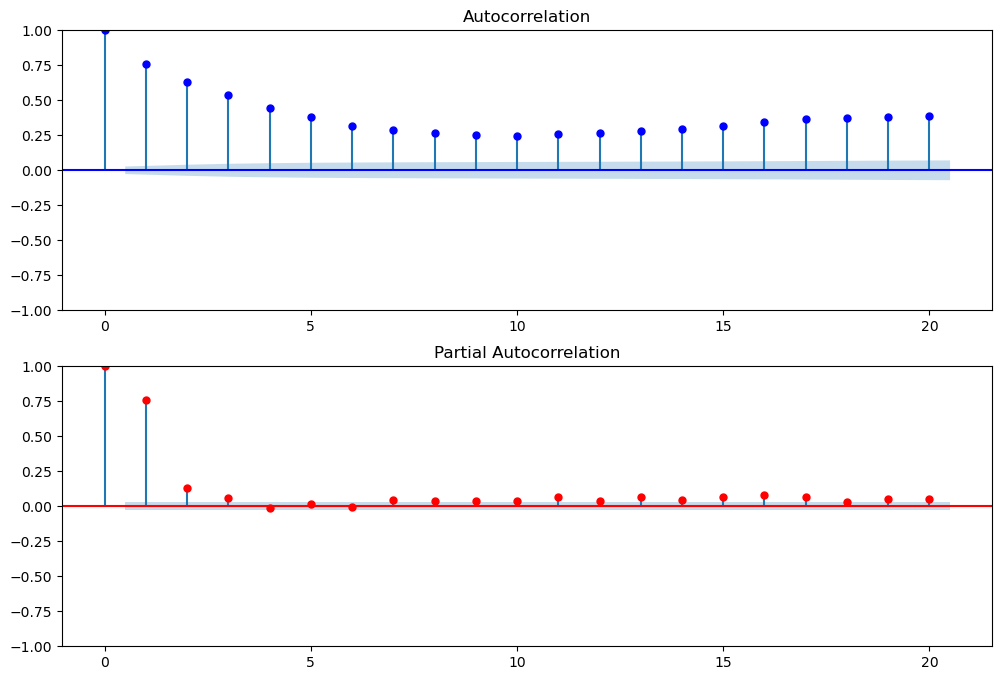

In [7]:
def adf_test(data_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(data_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(e_data['Consumption'].values.reshape(-1, 1))
adf_test(scaled_data)
adf_test(e_data['Consumption'])
acf_color = 'blue'
pacf_color = 'red'
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(e_data['Consumption'], lags=20, ax=axs[0], color=acf_color)
plot_pacf(e_data['Consumption'], lags=20, ax=axs[1], color=pacf_color)
plt.show()

#### Co2 Data

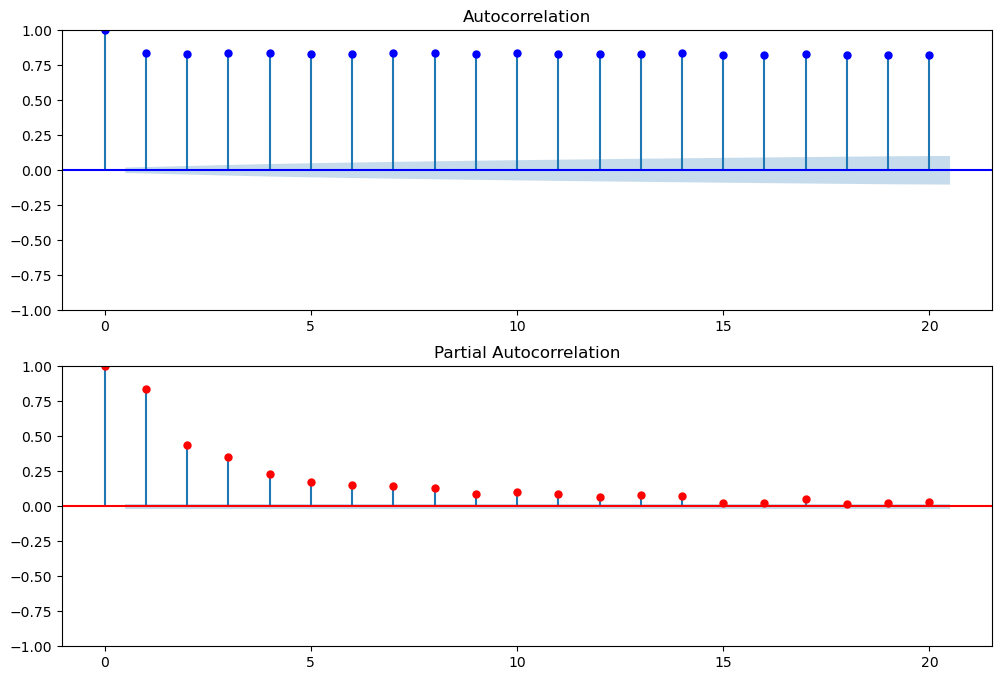

In [8]:
def adf_test(data_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ev_data['mean_xco2'], lags=20, ax=axs[0], color='blue')
plot_pacf(ev_data['mean_xco2'], lags=20, ax=axs[1], color='red')
plt.show()

### ANN (Neural Network)

#### Finance Data

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Model 1 MAE: 0.04255884920744144
Model 2 MAE: 0.07572362992488205
Model 1 RMSE: 0.20526255774270857
Model 2 RMSE: 0.176708556996627
Model 1 MSE: 0.042132724076509476
Model 2 MSE: 0.03122592158615589


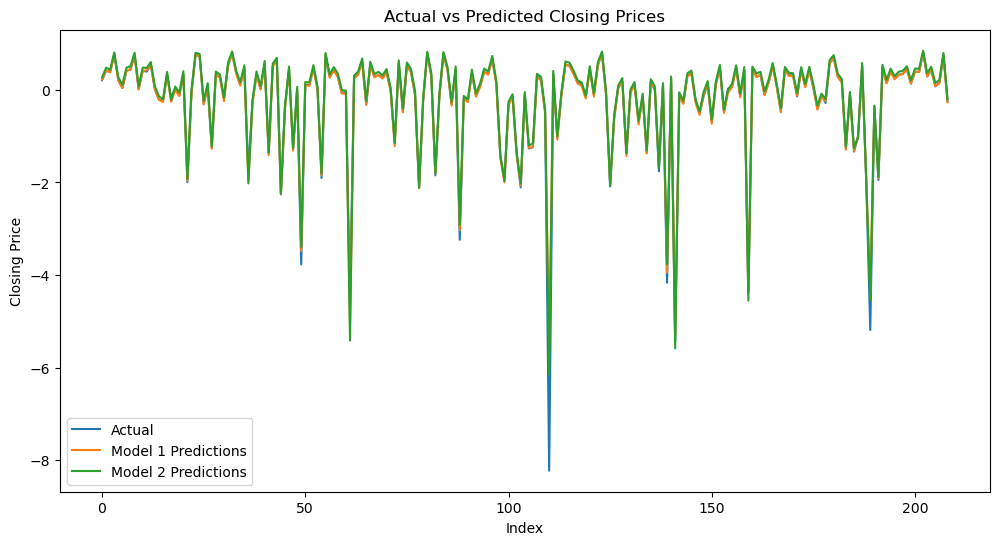

In [9]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(f_data[['Open', 'High', 'Low']])
X = scaled_data
y = f_data['Close/Last']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def create_model(num_layers, num_neurons):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model1 = create_model(2, 32)
model1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
model2 = create_model(3, 64)
model2.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)
mse1 = model1.evaluate(X_test, y_test, verbose=0)
mse2 = model2.evaluate(X_test, y_test, verbose=0)
mae1 = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)
rmse1 = mean_squared_error(y_test, preds1, squared=False)
rmse2 = mean_squared_error(y_test, preds2, squared=False)
print(f'Model 1 MAE: {mae1}')
print(f'Model 2 MAE: {mae2}')
print(f'Model 1 RMSE: {rmse1}')
print(f'Model 2 RMSE: {rmse2}')
print(f'Model 1 MSE: {mse1}')
print(f'Model 2 MSE: {mse2}')
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(preds1, label='Model 1 Predictions')
plt.plot(preds2, label='Model 2 Predictions')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Index')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

#### Energy Data

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Model 1 MAE: 0.017009494766378433
Model 2 MAE: 0.007755461760737742
Model 1 RMSE: 0.017844879713585393
Model 2 RMSE: 0.012329049500730896
Model 1 MSE: 0.0003184397319923315
Model 2 MSE: 0.00015200546159147276


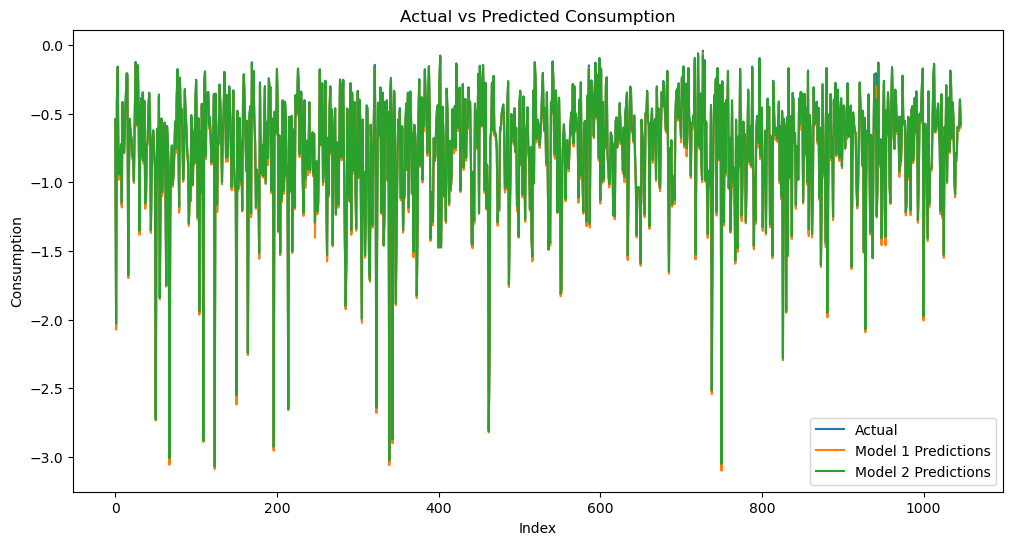

In [10]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(e_data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']])
X = scaled_data
y = e_data['Consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def create_model(num_layers, num_neurons):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model1 = create_model(2, 32)
model1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
model2 = create_model(3, 64)
model2.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)
mse1 = mean_squared_error(y_test, preds1)
mse2 = mean_squared_error(y_test, preds2)
mae1 = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)
rmse1 = mean_squared_error(y_test, preds1, squared=False)
rmse2 = mean_squared_error(y_test, preds2, squared=False)
print(f'Model 1 MAE: {mae1}')
print(f'Model 2 MAE: {mae2}')
print(f'Model 1 RMSE: {rmse1}')
print(f'Model 2 RMSE: {rmse2}')
print(f'Model 1 MSE: {mse1}')
print(f'Model 2 MSE: {mse2}')
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(preds1, label='Model 1 Predictions')
plt.plot(preds2, label='Model 2 Predictions')
plt.title('Actual vs Predicted Consumption')
plt.xlabel('Index')
plt.ylabel('Consumption')
plt.legend()
plt.show()

#### Co2 Data

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model 1 MAE: 0.10022451944170409
Model 2 MAE: 0.10190007873878681
Model 1 RMSE: 0.12921006833712578
Model 2 RMSE: 0.12799180341415192
Model 1 MSE: 0.016695240512490273
Model 2 MSE: 0.016381902620196342


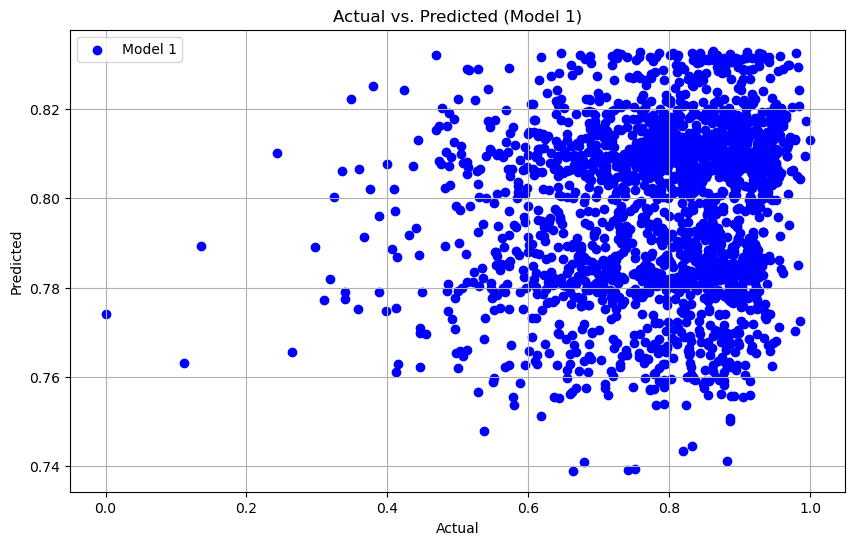

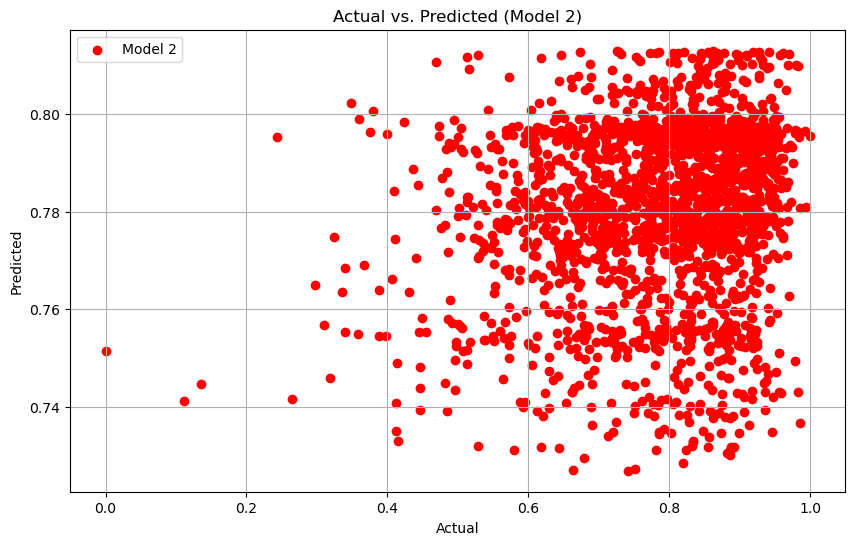

In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ev_data[['x', 'y', 'mean_xco2']])
X = scaled_data[:, :-1]
y = scaled_data[:, -1].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def create_model(num_layers, num_neurons):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model1 = create_model(2, 32)
model1.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
model2 = create_model(3, 64)
model2.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)
mse1 = model1.evaluate(X_test, y_test, verbose=0)
mse2 = model2.evaluate(X_test, y_test, verbose=0)
mae1 = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)
rmse1 = mean_squared_error(y_test, preds1, squared=False)
rmse2 = mean_squared_error(y_test, preds2, squared=False)
print(f'Model 1 MAE: {mae1}')
print(f'Model 2 MAE: {mae2}')
print(f'Model 1 RMSE: {rmse1}')
print(f'Model 2 RMSE: {rmse2}')
print(f'Model 1 MSE: {mse1}')
print(f'Model 2 MSE: {mse2}')
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds1, color='blue', label='Model 1')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (Model 1)')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds2, color='red', label='Model 2')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (Model 2)')
plt.legend()
plt.grid(True)
plt.show()

### SARIMA (Seasonal ARIMA)

#### Finanace Data

Results of Dickey-Fuller Test:
Test Statistic                   -3.149069
p-value                           0.023129
#Lags Used                       16.000000
Number of Observations Used    1025.000000
Critical Value (1%)              -3.436746
Critical Value (5%)              -2.864364
Critical Value (10%)             -2.568274
dtype: float64

ADF Test Results after seasonal differencing:
Test Statistic: -7.5145386752412175
p-value: 3.934907568127861e-11
Critical Values: {'1%': -3.436860474327014, '5%': -2.8644144230916537, '10%': -2.568300476140699}


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC: 225.4299640095345
BIC: 250.05793999508683
MAPE: nan


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\zorai\AppData\Local\Temp\ipykernel_22864\3397703441.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


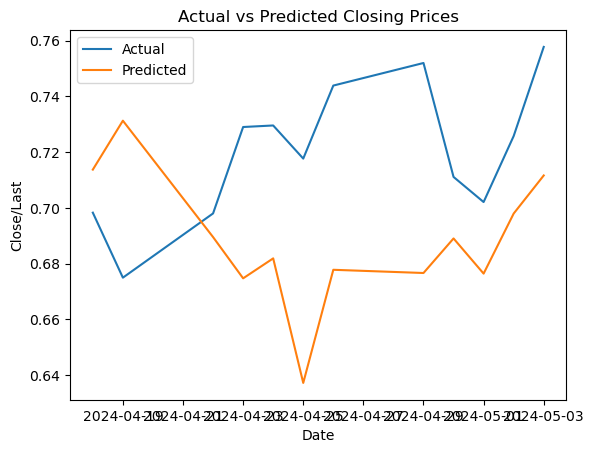

In [12]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
adf_test(f_data['Close/Last'])
seasonal_diff = f_data['Close/Last'].diff(12)  
seasonal_diff = seasonal_diff.dropna()
adf_seasonal_diff = adfuller(seasonal_diff)
print('\nADF Test Results after seasonal differencing:')
print('Test Statistic:', adf_seasonal_diff[0])
print('p-value:', adf_seasonal_diff[1])
print('Critical Values:', adf_seasonal_diff[4])
train_data = f_data.iloc[:-12]  # Exclude the last 12 months for testing
test_data = f_data.iloc[-12:]
p = 1
d = 0
q = 1
P = 1
D = 1
Q = 1
model = SARIMAX(train_data['Close/Last'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()
print('AIC:', results.aic)
print('BIC:', results.bic)
y_pred = results.predict(start=len(train_data), end=len(train_data)+11, dynamic=True)
mape = mean_absolute_percentage_error(test_data['Close/Last'], y_pred)
print('MAPE:', mape)
plt.plot(test_data.index, test_data['Close/Last'], label='Actual')
plt.plot(test_data.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close/Last')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

#### Energy Data

Results of Dickey-Fuller Test:
Test Statistic                -5.790398e+00
p-value                        4.887578e-07
#Lags Used                     2.500000e+01
Number of Observations Used    5.207000e+03
Critical Value (1%)           -3.431606e+00
Critical Value (5%)           -2.862095e+00
Critical Value (10%)          -2.567066e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -24.151950
p-value                           0.000000
#Lags Used                       24.000000
Number of Observations Used    5207.000000
Critical Value (1%)              -3.431606
Critical Value (5%)              -2.862095
Critical Value (10%)             -2.567066
dtype: float64


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 1771.3428706311124
BIC: 1804.1556150967976
MAPE: nan


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\zorai\AppData\Local\Temp\ipykernel_22864\3397703441.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


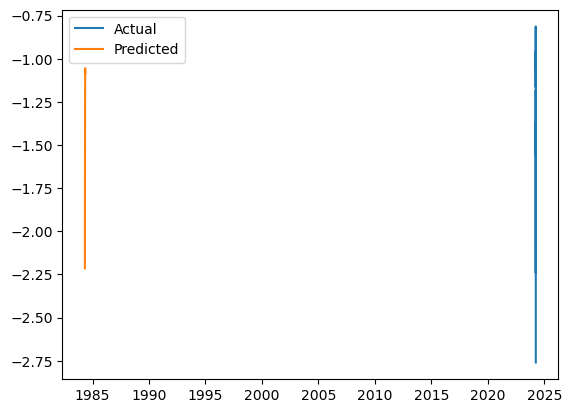

In [13]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

adf_test(e_data['Consumption'])
e_data['diff_Consumption'] = e_data['Consumption'] - e_data['Consumption'].shift(1)
e_data = e_data.dropna()
adf_test(e_data['diff_Consumption'])
p = 1
d = 0
q = 1
P = 1
D = 0
Q = 1

model = SARIMAX(e_data['Consumption'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()

print('AIC:', results.aic)
print('BIC:', results.bic)
y_pred = results.predict(start=len(e_data), end=len(e_data)+11, dynamic=True)
mape = mean_absolute_percentage_error(e_data['Consumption'].iloc[-12:], y_pred)
print('MAPE:', mape)
plt.plot(e_data['Consumption'].iloc[-12:], label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

#### Co2 Data

Results of Dickey-Fuller Test:
Test Statistic                   -2.749585
p-value                           0.065844
#Lags Used                       37.000000
Number of Observations Used    9960.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566924
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -25.118655
p-value                           0.000000
#Lags Used                       38.000000
Number of Observations Used    9958.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566925
dtype: float64


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC: -8694.904067692161
BIC: -8658.860372239114


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


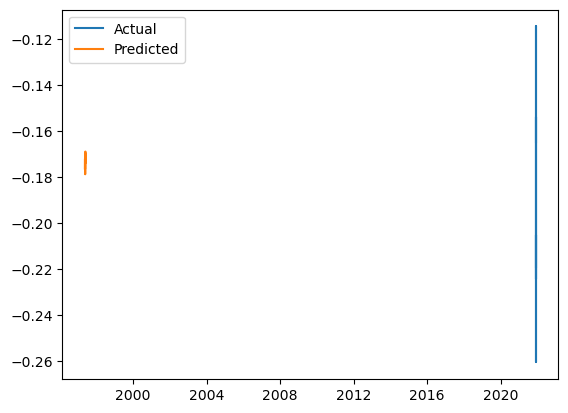

In [14]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
       dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
adf_test(ev_data['mean_xco2'])

ev_data['diff_mean_xco2'] = ev_data['mean_xco2'] - ev_data['mean_xco2'].shift(1)
ev_data = ev_data.dropna()
adf_test(ev_data['diff_mean_xco2'])
p = 1
d = 1
q = 1
P = 1
D = 1
Q = 1

model = SARIMAX(ev_data['mean_xco2'], order=(p, d, q), seasonal_order=(P, D, Q, 12))
results = model.fit()
print('AIC:', results.aic)
print('BIC:', results.bic)
y_pred = results.predict(start=len(ev_data), end=len(ev_data)+11, dynamic=True)
plt.plot(ev_data['mean_xco2'].iloc[-12:], label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

### Exponential Smoothing (ETS):

#### Finance Data

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\P

Simple Exponential Smoothing (SES) Forecast:
1042    0.744189
1043    0.744189
1044    0.744189
1045    0.744189
1046    0.744189
1047    0.744189
1048    0.744189
1049    0.744189
1050    0.744189
1051    0.744189
1052    0.744189
1053    0.744189
1054    0.744189
1055    0.744189
1056    0.744189
1057    0.744189
1058    0.744189
1059    0.744189
1060    0.744189
1061    0.744189
1062    0.744189
1063    0.744189
1064    0.744189
1065    0.744189
1066    0.744189
1067    0.744189
1068    0.744189
1069    0.744189
1070    0.744189
1071    0.744189
1072    0.744189
1073    0.744189
dtype: float64

Holt's Linear Trend (HLT) Forecast:
1042    0.747663
1043    0.749658
1044    0.751653
1045    0.753648
1046    0.755644
1047    0.757639
1048    0.759634
1049    0.761629
1050    0.763625
1051    0.765620
1052    0.767615
1053    0.769610
1054    0.771606
1055    0.773601
1056    0.775596
1057    0.777592
1058    0.779587
1059    0.781582
1060    0.783577
1061    0.785573
1062    0.787568
10

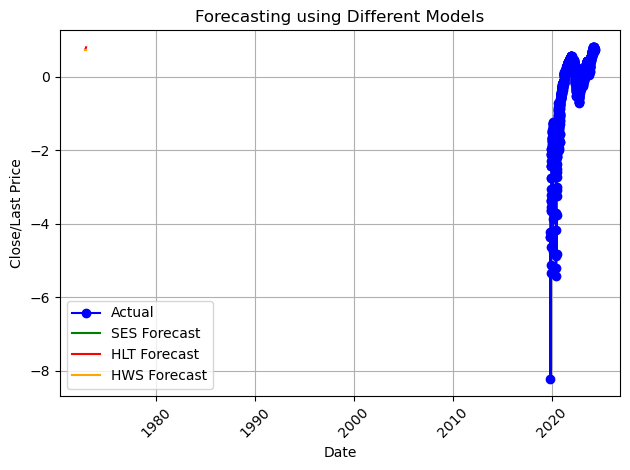

In [15]:
close_last = f_data['Close/Last']
ses_model = SimpleExpSmoothing(close_last)
ses_fit = ses_model.fit()
hlt_model = Holt(close_last)
hlt_fit = hlt_model.fit()
hws_model =ExponentialSmoothing(close_last, seasonal_periods=12)
hws_fit = hws_model.fit()
ses_forecast = ses_fit.forecast(steps=32)
hlt_forecast = hlt_fit.forecast(steps=32)
hws_forecast = hws_fit.forecast(steps=32)
print("Simple Exponential Smoothing (SES) Forecast:")
print(ses_forecast)
print("\nHolt's Linear Trend (HLT) Forecast:")
print(hlt_forecast)
print("\nHolt-Winters' Seasonal (HWS) Forecast:")
print(hws_forecast)
plt.plot(close_last.index, close_last, label='Actual', marker='o', color='blue')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', color='green')
plt.plot(hlt_forecast.index, hlt_forecast, label="HLT Forecast", color='red')
plt.plot(hws_forecast.index, hws_forecast, label="HWS Forecast", color='orange')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.title('Forecasting using Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Energy Data

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\P

Simple Exponential Smoothing (SES) Forecast:
35   -0.048186
36   -0.048186
37   -0.048186
38   -0.048186
39   -0.048186
40   -0.048186
41   -0.048186
42   -0.048186
43   -0.048186
44   -0.048186
45   -0.048186
46   -0.048186
47   -0.048186
48   -0.048186
49   -0.048186
50   -0.048186
51   -0.048186
52   -0.048186
53   -0.048186
54   -0.048186
55   -0.048186
56   -0.048186
57   -0.048186
58   -0.048186
59   -0.048186
60   -0.048186
61   -0.048186
62   -0.048186
63   -0.048186
64   -0.048186
65   -0.048186
66   -0.048186
dtype: float64

Holt's Linear Trend (HLT) Forecast:
35   -0.013377
36    0.015902
37    0.045181
38    0.074460
39    0.103739
40    0.133018
41    0.162297
42    0.191575
43    0.220854
44    0.250133
45    0.279412
46    0.308691
47    0.337970
48    0.367249
49    0.396528
50    0.425807
51    0.455086
52    0.484365
53    0.513644
54    0.542923
55    0.572202
56    0.601481
57    0.630760
58    0.660039
59    0.689318
60    0.718597
61    0.747876
62    0.777155
63 

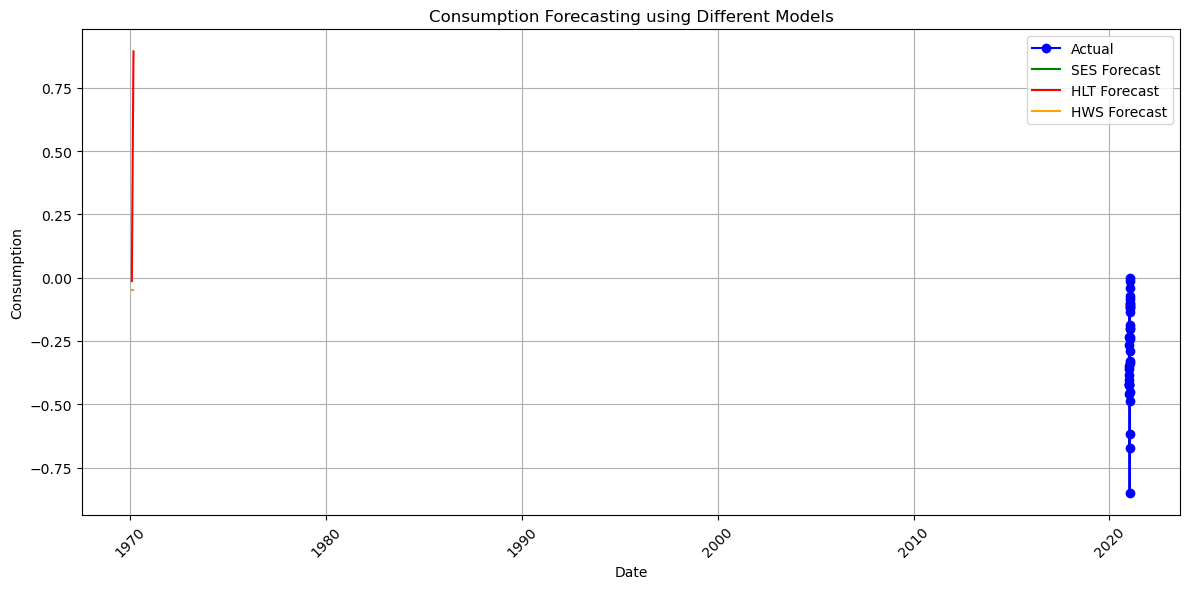

In [16]:
consumption = e_data['Consumption']
consumption = consumption[1990:2025]
ses_model = SimpleExpSmoothing(consumption)
ses_fit = ses_model.fit()
hlt_model = Holt(consumption)
hlt_fit = hlt_model.fit()
hws_model = ExponentialSmoothing(consumption, seasonal_periods=24)
hws_fit = hws_model.fit()
ses_forecast = ses_fit.forecast(steps=32)
hlt_forecast = hlt_fit.forecast(steps=32)
hws_forecast = hws_fit.forecast(steps=32)
print("Simple Exponential Smoothing (SES) Forecast:")
print(ses_forecast)
print("\nHolt's Linear Trend (HLT) Forecast:")
print(hlt_forecast)
print("\nHolt-Winters' Seasonal (HWS) Forecast:")
print(hws_forecast)
plt.figure(figsize=(12, 6))
plt.plot(consumption.index, consumption, label='Actual', marker='o', color='blue')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', color='green')
plt.plot(hlt_forecast.index, hlt_forecast, label="HLT Forecast", color='red')
plt.plot(hws_forecast.index, hws_forecast, label="HWS Forecast", color='orange')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Consumption Forecasting using Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Co2 Data

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\P

Simple Exponential Smoothing (SES) Forecast:
9997    -0.633355
9998    -0.633355
9999    -0.633355
10000   -0.633355
10001   -0.633355
10002   -0.633355
10003   -0.633355
10004   -0.633355
10005   -0.633355
10006   -0.633355
10007   -0.633355
10008   -0.633355
10009   -0.633355
10010   -0.633355
10011   -0.633355
10012   -0.633355
10013   -0.633355
10014   -0.633355
10015   -0.633355
10016   -0.633355
10017   -0.633355
10018   -0.633355
10019   -0.633355
10020   -0.633355
10021   -0.633355
10022   -0.633355
10023   -0.633355
10024   -0.633355
10025   -0.633355
10026   -0.633355
10027   -0.633355
10028   -0.633355
dtype: float64

Holt's Linear Trend (HLT) Forecast:
9997    -0.654094
9998    -0.655989
9999    -0.657884
10000   -0.659778
10001   -0.661673
10002   -0.663568
10003   -0.665462
10004   -0.667357
10005   -0.669252
10006   -0.671147
10007   -0.673041
10008   -0.674936
10009   -0.676831
10010   -0.678725
10011   -0.680620
10012   -0.682515
10013   -0.684410
10014   -0.686304
100

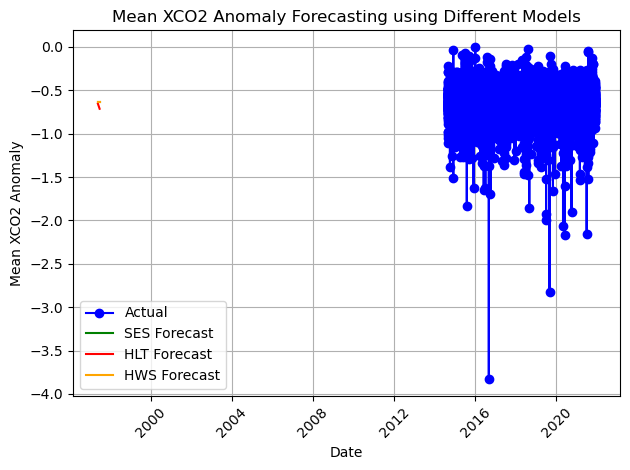

In [17]:
mean_xco2_anomaly = ev_data['mean_xco2_anomaly']
ses_model = SimpleExpSmoothing(mean_xco2_anomaly)
ses_fit = ses_model.fit()
hlt_model = Holt(mean_xco2_anomaly)
hlt_fit = hlt_model.fit()
hws_model = ExponentialSmoothing(mean_xco2_anomaly, seasonal_periods=12)
hws_fit = hws_model.fit()
ses_forecast = ses_fit.forecast(steps=32)
hlt_forecast = hlt_fit.forecast(steps=32)
hws_forecast = hws_fit.forecast(steps=32)
print("Simple Exponential Smoothing (SES) Forecast:")
print(ses_forecast)
print("\nHolt's Linear Trend (HLT) Forecast:")
print(hlt_forecast)
print("\nHolt-Winters' Seasonal (HWS) Forecast:")
print(hws_forecast)
plt.plot(mean_xco2_anomaly.index, mean_xco2_anomaly, label='Actual', marker='o', color='blue')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast', color='green')
plt.plot(hlt_forecast.index, hlt_forecast, label="HLT Forecast", color='red')
plt.plot(hws_forecast.index, hws_forecast, label="HWS Forecast", color='orange')
plt.xlabel('Date')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('Mean XCO2 Anomaly Forecasting using Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Prophet

### Finance Data

12:20:31 - cmdstanpy - INFO - Chain [1] start processing
12:20:31 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


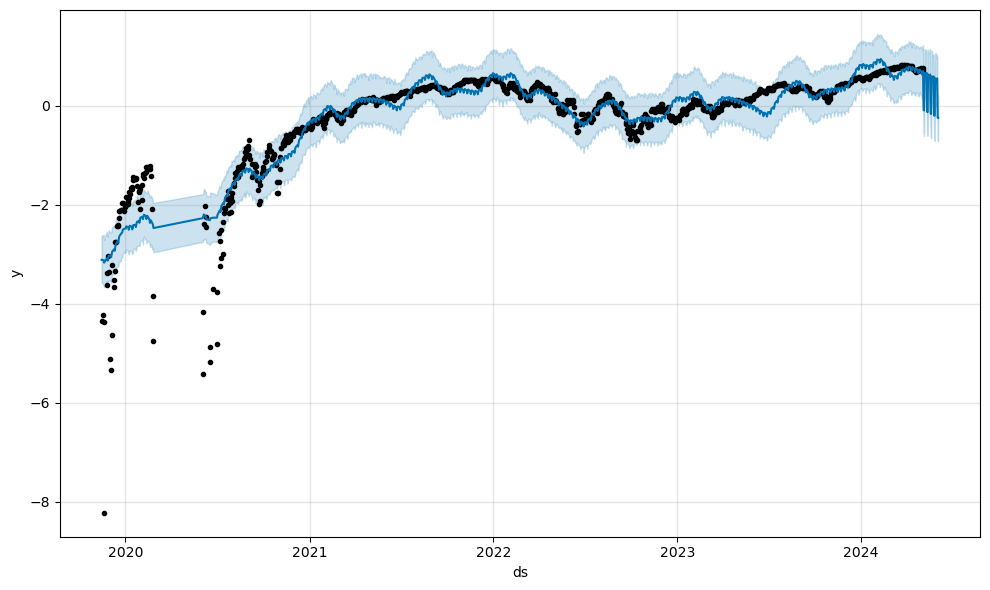

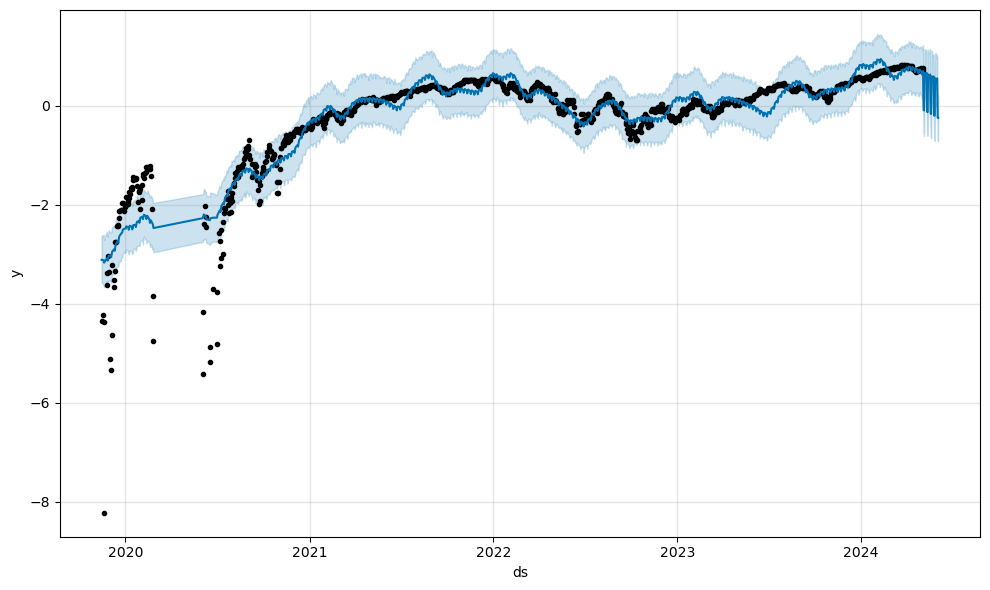

In [18]:
f_data_prophet = f_data[['Date', 'Close/Last']].rename(columns={'Date': 'ds', 'Close/Last': 'y'})
model = Prophet()
model.fit(f_data_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
model.plot(forecast)

#### Energy Data

12:20:34 - cmdstanpy - INFO - Chain [1] start processing
12:20:37 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


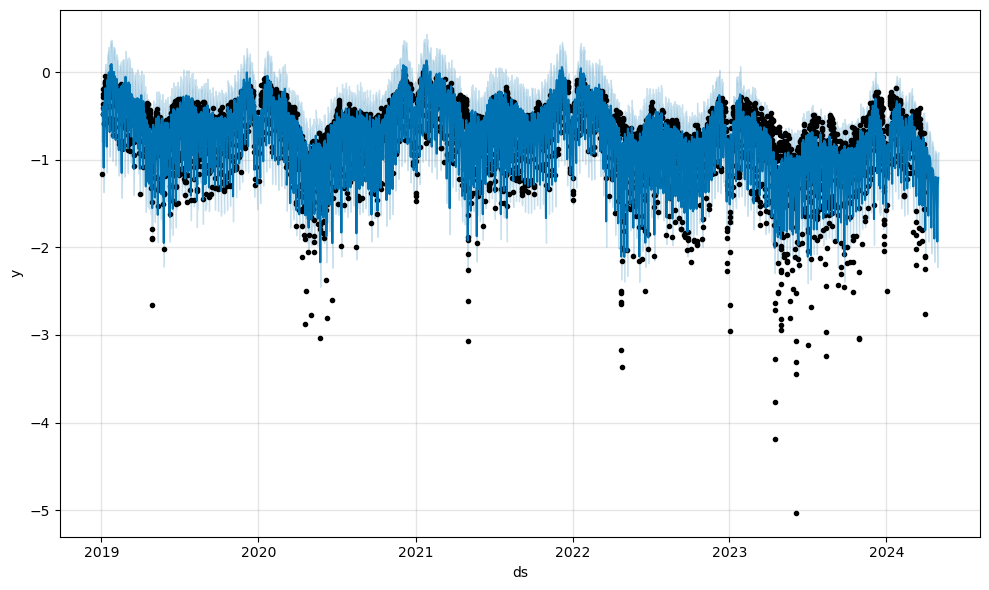

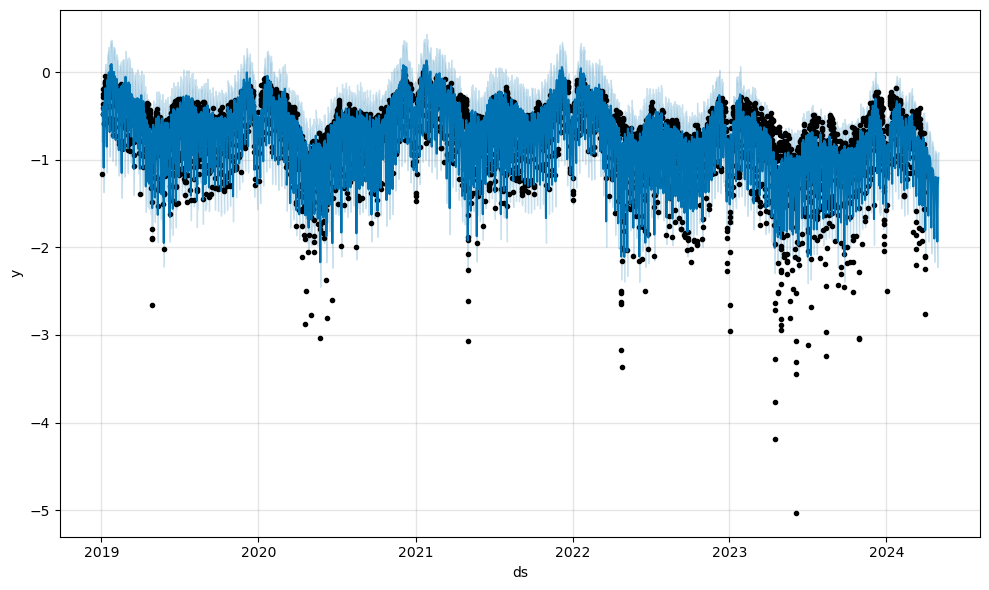

In [19]:
e_data['DateTime'] = e_data.index
e_data_prophet = e_data[['DateTime', 'Consumption']].rename(columns={'DateTime': 'ds', 'Consumption': 'y'})
model = Prophet()
model.fit(e_data_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
model.plot(forecast)

#### Co2 Data

12:20:42 - cmdstanpy - INFO - Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


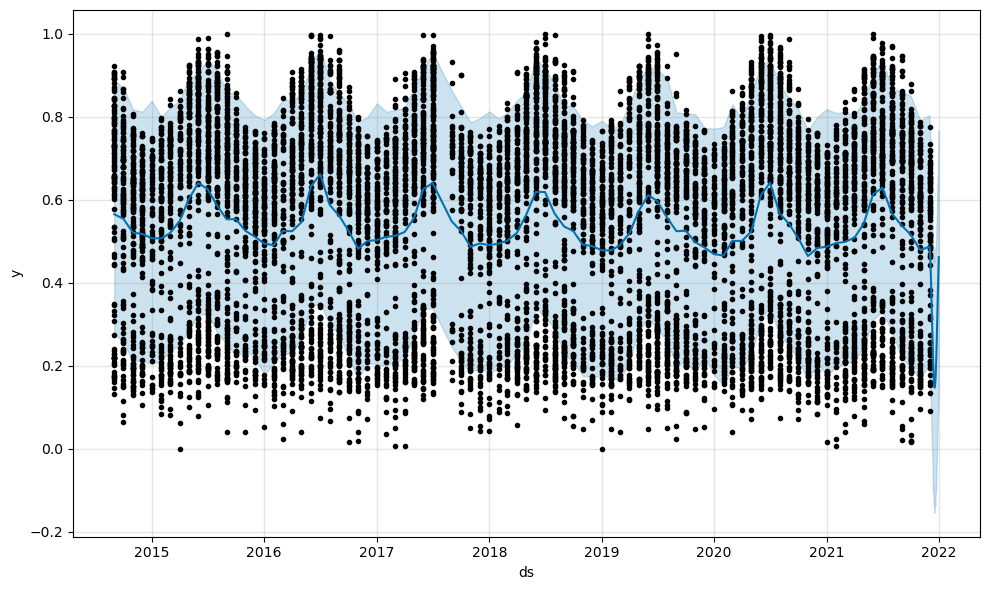

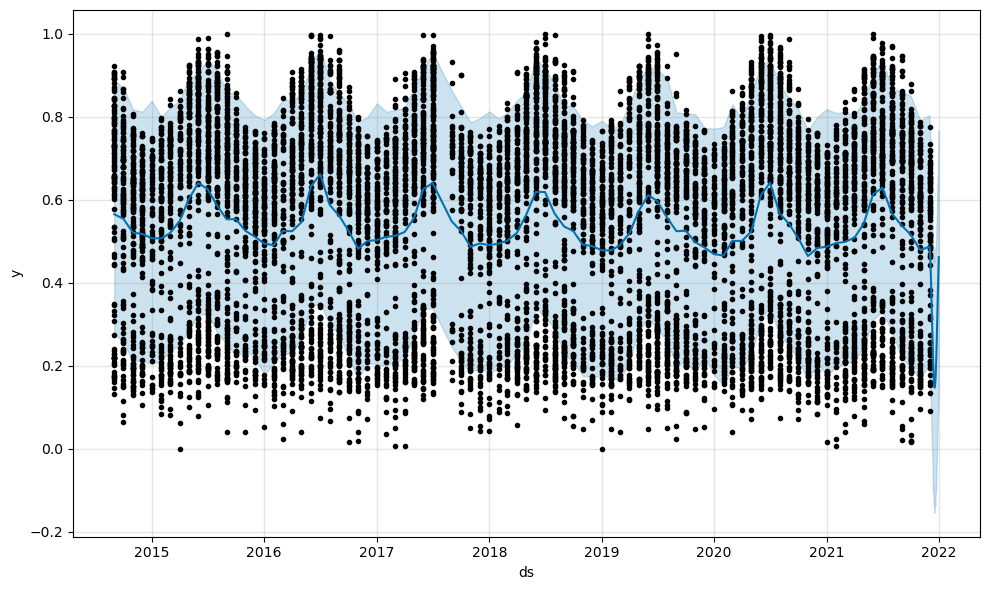

In [20]:
ev_data['Date'] = ev_data.index
ev_data_prophet = ev_data[['Date', 'y']].rename(columns={'Date': 'ds', 'y': 'y'})
model = Prophet()
model.fit(ev_data_prophet)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
model.plot(forecast)

### Support Vector Regression (SVR)

### Finance Data

Mean squared error: 0.11881131585220461


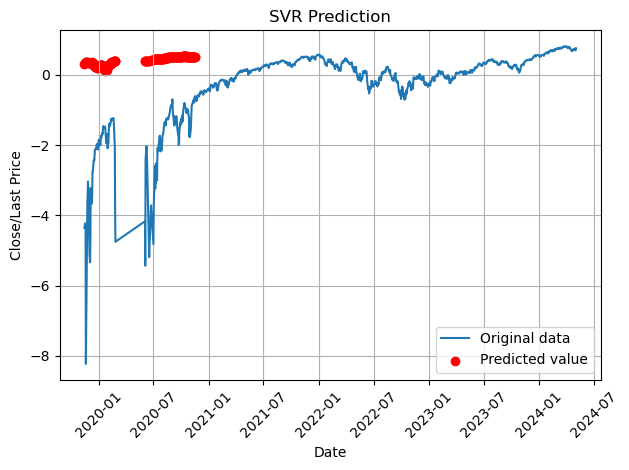

In [21]:
X = f_data[['Open', 'High', 'Low']].values
y = f_data['Close/Last'].values
def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)
model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)
X_pred = f_data[['Open', 'High', 'Low']].tail(1).values
y_pred = model.predict(X_pred)
tscv = TimeSeriesSplit(n_splits=5)
scores = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)
print('Mean squared error:', np.mean(scores))
plt.plot(f_data.index, f_data['Close/Last'], label='Original data')
plt.scatter( f_data.index[0:173],y_pred, color='red', label='Predicted value')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.title('SVR Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Energy Data

Mean squared error: 0.9121434135215962


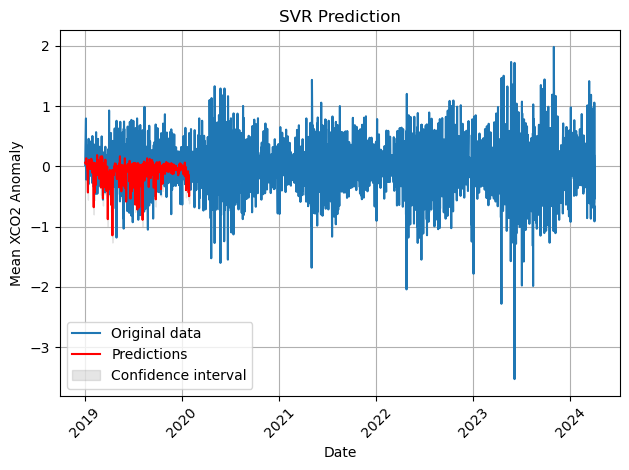

In [22]:
X = e_data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']].values
y = e_data['diff_Consumption'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)

model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)
X_pred = np.array([e_data[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']].tail(1).values[0]])
y_pred = model.predict(X_pred)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)

print('Mean squared error:', np.mean(scores))
upper_bound = y_pred + np.std(y_pred)
lower_bound = y_pred - np.std(y_pred)
a = y_pred.size
plt.plot(e_data.index, e_data['diff_Consumption'], label='Original data')
plt.plot(e_data.index[0:a], y_pred, color='red', label='Predictions')
plt.fill_between(e_data.index[0:a], upper_bound, lower_bound, color='gray', alpha=0.2, label='Confidence interval')

plt.xlabel('Date')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('SVR Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Co2 Data

Mean squared error: 1.4304506692454837


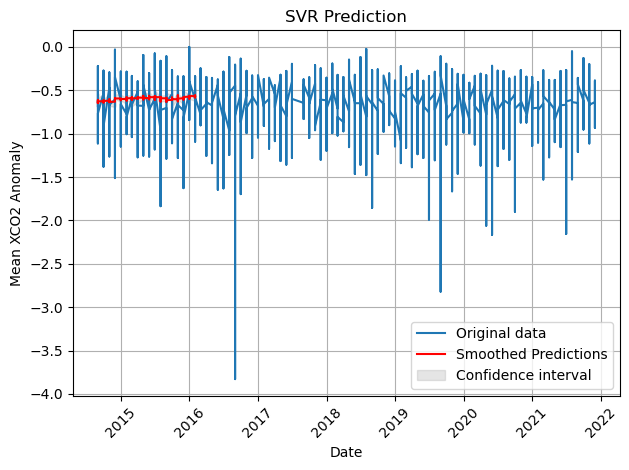

In [23]:
X = ev_data[['x', 'y', 'mean_xco2']].values
y = ev_data['mean_xco2_anomaly'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()
def svr(X, y, C=1.0, kernel='rbf', gamma=0.1):
    model = SVR(C=C, kernel=kernel, gamma=gamma)
    return model.fit(X, y)
model = svr(X, y, C=1.0, kernel='rbf', gamma=0.1)
X_pred = np.array([ev_data[['x', 'y', 'mean_xco2']].tail(1).values[0]])
y_pred = model.predict(X_pred)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = svr(X_train, y_train, C=1.0, kernel='rbf', gamma=0.1)
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    score = np.mean((y_pred - y_test)**2)
    scores.append(score)
print('Mean squared error:', np.mean(scores))
upper_bound = y_pred + np.std(y_pred)
lower_bound = y_pred - np.std(y_pred)

smoothed_y_pred = gaussian_filter1d(y_pred, sigma=3)

plt.plot(ev_data.index, ev_data['mean_xco2_anomaly'], label='Original data')
plt.plot(ev_data.index[0:1999], smoothed_y_pred, color='red', label='Smoothed Predictions')
plt.fill_between(ev_data.index[0:1999], upper_bound, lower_bound, color='gray', alpha=0.2, label='Confidence interval')

plt.xlabel('Date')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('SVR Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Long Short-Term Memory (LSTM)

#### Finance Data

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
[[0.4709322]]


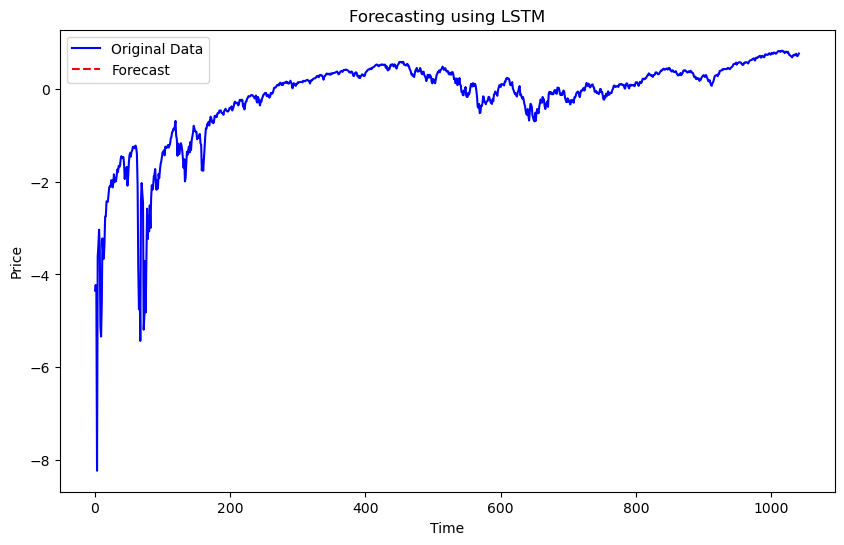

In [24]:
data = f_data['Close/Last'].values
sequence_length = 50
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=0)
forecast_sequence = data[-sequence_length:]
forecast_sequence = np.array(forecast_sequence).reshape((1, sequence_length, 1))
forecast_sequence = (forecast_sequence - mean) / std
forecast = model.predict(forecast_sequence)
forecast = forecast * std + mean
print(forecast)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)), data, color='blue', label='Original Data')
plt.plot(np.arange(len(data), len(data) + len(forecast[0])), forecast[0], color='red', label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Forecasting using LSTM')
plt.legend()
plt.show()

#### Energy Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
[[-1.6176035]]


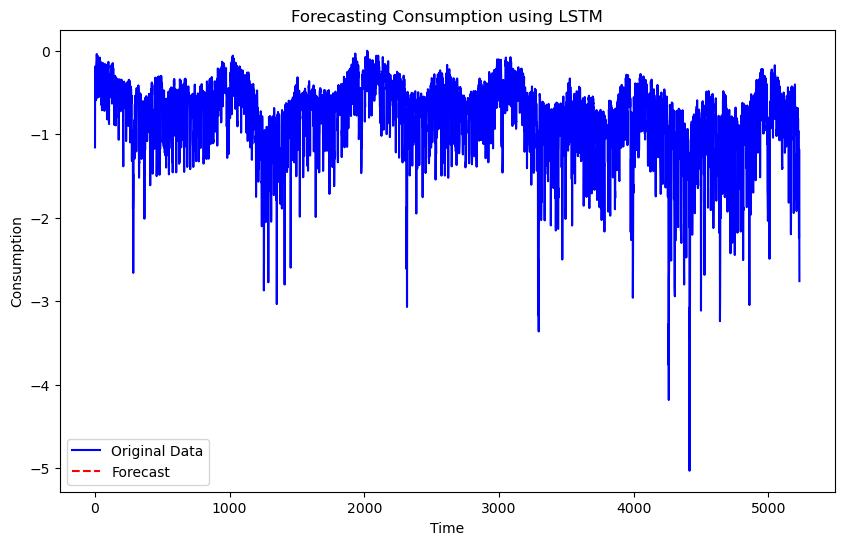

In [25]:
data = e_data['Consumption'].values
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=0)
forecast_sequence = data[-sequence_length:]
forecast_sequence = np.array(forecast_sequence).reshape((1, sequence_length, 1))
forecast_sequence = (forecast_sequence - mean) / std
forecast = model.predict(forecast_sequence)
forecast = forecast * std + mean
print(forecast)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)), data, color='blue', label='Original Data')
plt.plot(np.arange(len(data), len(data) + len(forecast[0])), forecast[0], color='red', label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Forecasting Consumption using LSTM')
plt.legend()
plt.show()

#### Co2 Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
[[-0.75769883]]


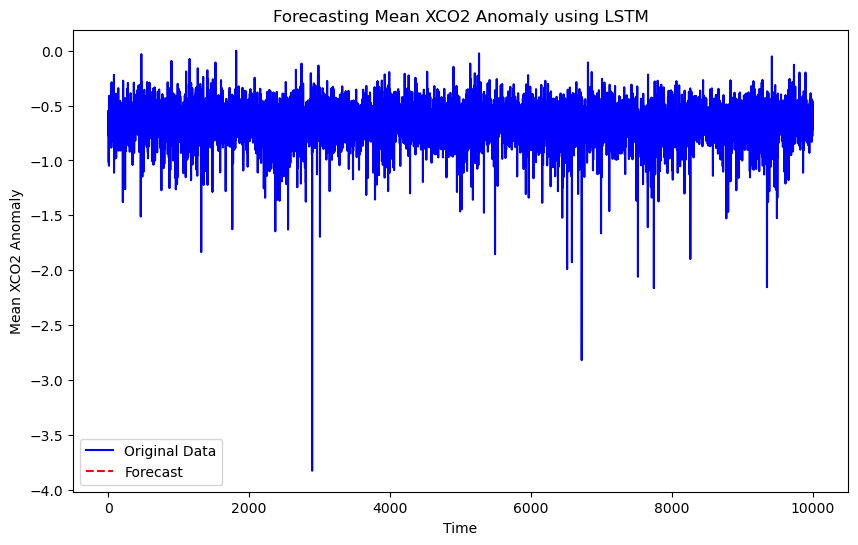

In [26]:
data = ev_data['mean_xco2_anomaly'].values
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i-sequence_length:i])
    y.append(data[i])
X, y = np.array(X), np.array(y)
mean = np.mean(X)
std = np.std(X)
X = (X - mean) / std
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=0)
forecast_sequence = data[-sequence_length:]
forecast_sequence = np.array(forecast_sequence).reshape((1, sequence_length, 1))
forecast_sequence = (forecast_sequence - mean) / std
forecast = model.predict(forecast_sequence)
forecast = forecast * std + mean
print(forecast)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)), data, color='blue', label='Original Data')
plt.plot(np.arange(len(data), len(data) + len(forecast[0])), forecast[0], color='red', label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Mean XCO2 Anomaly')
plt.title('Forecasting Mean XCO2 Anomaly using LSTM')
plt.legend()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.9368
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0043
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0427
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9922
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2222
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9783
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9890
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9752
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0169
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9628
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0204
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1849
Epoch 13/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9645
Epoch 14/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9842
Epoch 15/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - lo

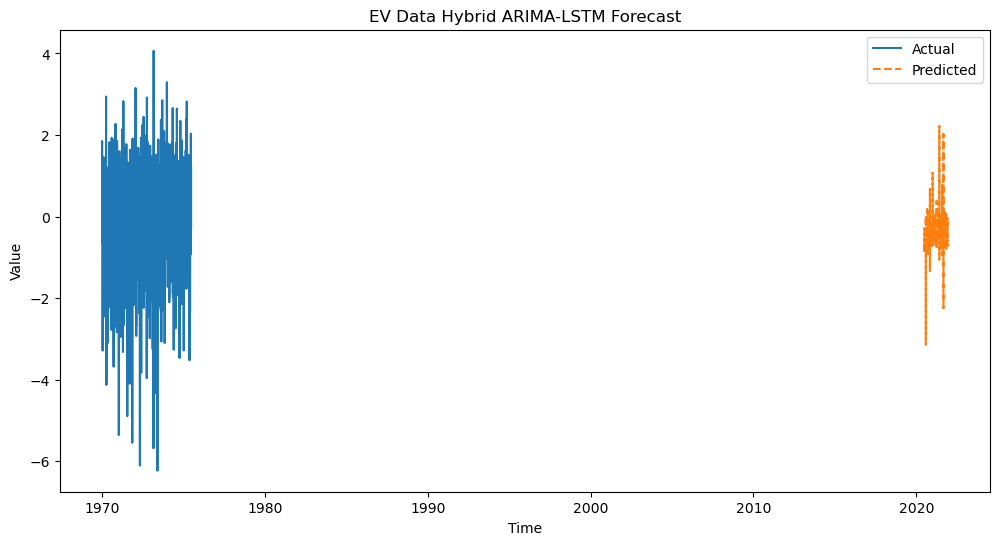

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

Epoch 1/50


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0088
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9351
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0870
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9927
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9950
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9239
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9351
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0341
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9293
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9840
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0696
Epoch 12/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9490
Epoch 13/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9335
Epoch 14/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9564
Epoch 15/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9702


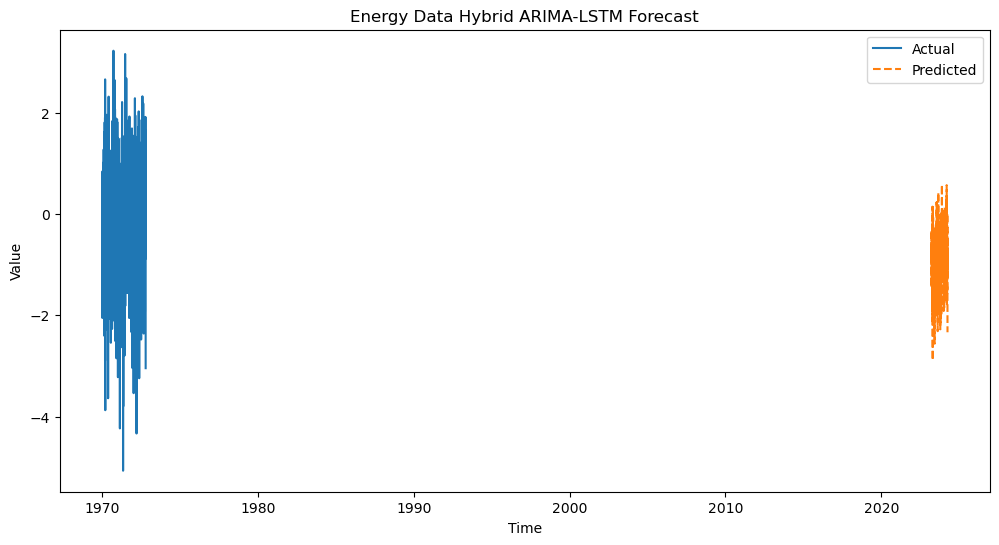

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5381
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5327
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8262
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6127
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4451
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4356
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5873
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6031
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5013
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5603
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4884
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5424
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4968
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6503
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5158
Epoch 16/50
26/26 ━

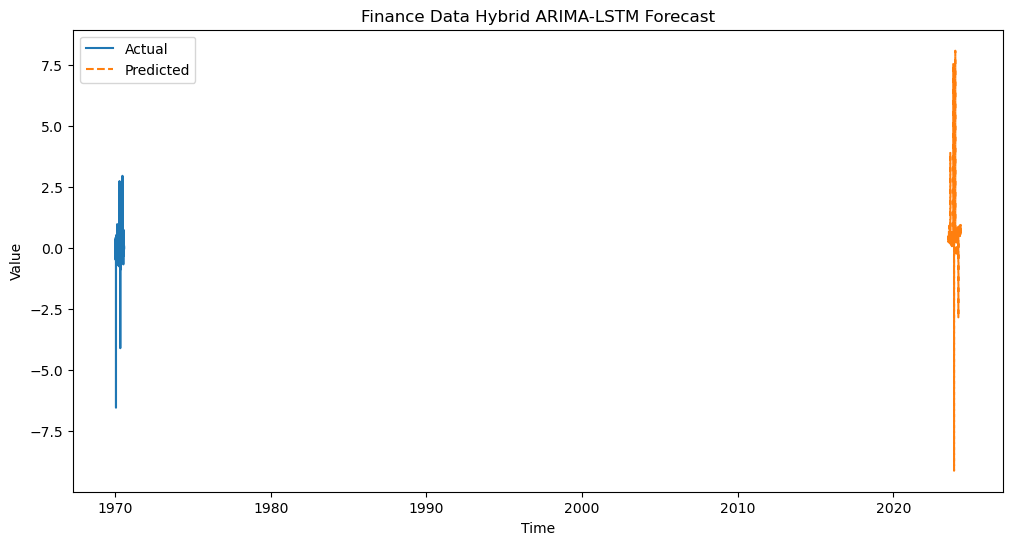

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Function to train the best ARIMA model
def train_best_arima_model(df, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(df, order=order)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                except:
                    continue
    return ARIMA(df, order=best_cfg).fit()

# Function to train the LSTM model
def train_lstm_model(X_train, y_train, input_dim, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(input_dim, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Function to create windowed data for LSTM
def create_windowed_data(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[i:i+window_size])
        y.append(df[i+window_size])
    return np.array(X), np.array(y)

# Function to evaluate and plot the model
def evaluate_hybrid_model(y_true, y_pred, title):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Function to run hybrid model
def run_hybrid_model(df, feature, p_values, d_values, q_values, title):
    data_for_arima = df[[feature]].dropna()
    
    # ARIMA model
    arima_model = train_best_arima_model(data_for_arima, p_values, d_values, q_values)
    arima_pred = arima_model.predict(start=1, end=len(data_for_arima) - 1)
    residuals = data_for_arima.iloc[1:][feature] - arima_pred

    # ANN model for residuals
    scaler = StandardScaler()
    residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))
    window_size = 5  # Adjustable window size for ANN input
    X, y = create_windowed_data(residuals_scaled, window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lstm_model = train_lstm_model(X_train, y_train, input_dim=window_size)
    ann_pred = lstm_model.predict(X_test)

    # Adjusting arima_pred to have the same length as ann_pred
    arima_pred_trimmed = arima_pred[-len(ann_pred):]

    # Combine ARIMA and ANN predictions
    combined_pred = arima_pred_trimmed + ann_pred.flatten()
    evaluate_hybrid_model(y_test.flatten(), combined_pred, title)


# Run hybrid models with tuned ARIMA and LSTM on datasets
# Specify p, d, q values to search
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3, 4, 5]

# Example usage
run_hybrid_model(ev_data, 'mean_xco2', p_values, d_values, q_values, "EV Data Hybrid ARIMA-LSTM Forecast")
run_hybrid_model(e_data, 'Consumption', p_values, d_values, q_values, "Energy Data Hybrid ARIMA-LSTM Forecast")
run_hybrid_model(f_data, 'Close/Last', p_values, d_values, q_values, "Finance Data Hybrid ARIMA-LSTM Forecast")
